<font size="6">**Computing Growth-Coupling Algorithms - Advanced**</font>

**Requirements**
- Growth-coupling suite (gcOpt)
- Escher maps module (https://escher.github.io/#/)
- Activated version of the Gurobi solver (https://www.gurobi.com/)

**Additional features**
- Consider Gene-Protein-Reaction relations to evaluate design solutions during the optimization
- Specify experimentally determined essential genes/reactions
- Find the optimal carbon source for growth-coupling
- Find a cofeed strategy to improve growth-coupling
- Run multiple gcOpt instances in parallel

# Modules and Packages

In [1]:
from growth_coupling_suite.gcOpt_algorithm import gcOpt # main gcOpt module 
from growth_coupling_suite.strain_analysis.strain_design_analysis import StrainDesignAnalyzer as SDA# a custom toolbox for the analysis of strains and designs

import cobra # COBRApy
import escher # Escher maps module

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

from pathlib import Path # module for handling paths to directories and files

# Files and Folders

In [2]:
MODEL_PATH = Path(r"Models/")
DATA_PATH = Path(r"Data/")

# Load, Prepare, and Analyze the Metabolic model
Load the **metabolic model** from a file and apply constraints to mimic the desired **environmental conditions, medium, and strain specific features**
## Prepare the model

In [3]:
# load a model of the core metabolism of E. coli K12 MG1655 including the 1,4-butanediol synthesis pathway
model = cobra.io.load_json_model(str(MODEL_PATH.joinpath("iML1515Core_exchange_14butanediol.json"))) # load from file

# set consraints
model.reactions.get_by_id("EX_glc__D_e").lower_bound = -18 # enable the glucose uptake flux
model.reactions.get_by_id("EX_o2_e").lower_bound = -2 # limit the oxygen uptake flux, microaerobic condition
model.reactions.get_by_id("EX_co2_e").lower_bound = 0 # disable CO2 uptake

# define the target reaction
target_reaction = "EX_14btdl_e"

# define factors to transform units to mass scale
unit_transformation_factors = {
    "EX_14btdl_e": model.metabolites.get_by_id("14btdl_e").formula_weight / 1000,
    "EX_glc__D_e": model.metabolites.get_by_id("glc__D_e").formula_weight / 1000
}

Using license file C:\Users\Tobi\gurobi.lic
Academic license - for non-commercial use only - expires 2022-08-07


## Simulate basic properties

Read LP format model from file C:\Users\Tobi\AppData\Local\Temp\tmpub6w3g_b.lp
Reading time = 0.01 seconds
: 714 rows, 1752 columns, 6812 nonzeros
Read LP format model from file C:\Users\Tobi\AppData\Local\Temp\tmpgyhpo6kc.lp
Reading time = 0.01 seconds
: 714 rows, 1752 columns, 6812 nonzeros
Apply parsed strain design ()...
	No medium composition provided
	No design interventions provided
No solutions in provided dictionary


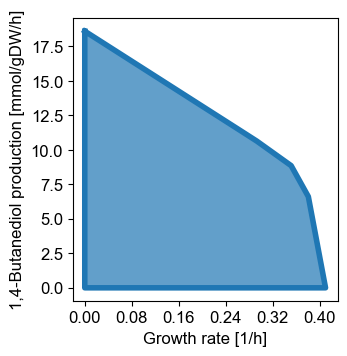

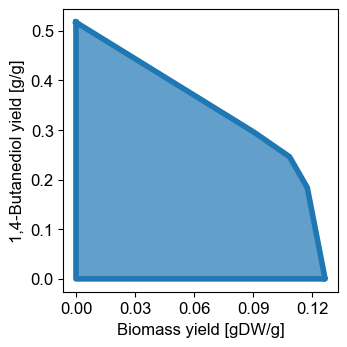

In [11]:
# print itaconate production capability
sda = SDA(model=model) # load StrainDesignAnalyzer
# flux space
ax = sda.flux_space_projection(target_rxn=target_reaction,
                               plot=True, dpi=100,
                               xlabel="Growth rate [1/h]", ylabel="1,4-Butanediol production [mmol/gDW/h]",
                               yield_space=False, yield_reference_reaction="EX_glc__D_e")

# yield space
ax = sda.flux_space_projection(target_rxn=target_reaction,
                               plot=True, dpi=100,
                               xlabel="Biomass yield [gDW/g]", ylabel="1,4-Butanediol yield [g/g]",
                               unit_transformation_factors=unit_transformation_factors,
                               yield_space=True, yield_reference_reaction="EX_glc__D_e")


In [5]:
# plot in flux map
builder = escher.Builder(
    map_json=str(MODEL_PATH.joinpath("e_coli_central_metabolism_butanediol_escher_map.json")),   
)
builder.model = model

# calculate flux distribution
sol = cobra.flux_analysis.pfba(model)

# show flux distribution in map
builder.reaction_data = sol.fluxes
builder

Builder(reaction_data={'NDPK5': 0.0, 'SHK3Dr': 0.1562455531459291, 'NDPK6': 0.0, 'NDPK8': 0.0, 'DHORTS': -0.13…

# Load Data
## Essential genes

In [6]:
# load a list of essential genes for E. coli K12 MG1655
essential_genes = pd.read_excel(DATA_PATH.joinpath("Essential_genes_Ecoli_MG1655.xlsx"), engine="openpyxl", sheet_name="Essential_Genes")

# determine correpsonding reactions of essential genes
essential_reactions = []
for g in essential_genes["bnumber"].tolist():
    if g in model.genes:
        for r in model.genes.get_by_id(g).reactions:
            essential_reactions.append(r.id)

essential_reactions = list(np.unique(essential_reactions))

# Calculation of Growth-Coupling Strain Designs

![Scheme of the growth-coupling optimization algorithm](Images/gcopt_principle_scheme.png)

For more information about the optimization algorithm and a general investigation of its solutions refer to https://doi.org/10.1186/s12859-019-2946-7

## The configuration file
- The main parameters and options for running gcOpt are set via the configuration file **config_advanced.py**
- For parameters not set in the configuration file default values are used

In [5]:
import config_advanced as config

## Growth-coupling algorithm setup

- Multiple gcOpt instances will be run in parallel to cover a range of parameters
    - Avoid overloading of your CPU. Number of parallel instances (cf "optimize_series") times number of processes (cf. config file) should not exceed the maximum number of available threads 

- If a model is used for the first time, heterologous reactions are extracted from various metabolic reconstructions (cf. BIGG database)
    - Reaction stoichiometries and metadata is curated by querying KEGG database (https://www.kegg.jp/)
    - If specified in the config file, reaction directions are curated based on thermodynamic considerations using the Equilibrator toolbox (https://equilibrator.weizmann.ac.il/)
    - Building a heterologous reaction database for a model can take a considerable amount of time!
    - The final heterologous reaction database is saved and will automatically be loaded the next time the model is used in gcOpt (the model ID is decisive here) 

In [8]:
# exclude essential reactions from target space
config.deletion_exclude_list.extend(essential_reactions)

# specify parameter sets which are run in parallel
parameters_parallel = [
    {"num_total_interventions": 6, "num_deletions": 5, "num_addins": 5, "output_file_id": "i6_k5_a5_cs1_cf1"},
    {"num_total_interventions": 8, "num_deletions": 7, "num_addins": 7, "output_file_id": "i8_d7_a7_cs1_cf1"},
    {"num_total_interventions": 11, "num_deletions": 10, "num_addins": 10,"output_file_id": "i11_d10_a10_cs1_cf1"},
]

# for each parameter set in "parameters_parallel" vary parameters sequentially
parameters_sequential = [
        {"growth_rate_fix": 0.1, "output_suffix": "gr_01"},
        {"growth_rate_fix": 0.3, "output_suffix": "gr_03"},
    ]

## Growth-coupling algorithm execution

In [9]:
if __name__ == "__main__": # necessary to avoid repeated call of this code block by the multiprocessing module
    # load gcOpt class
    GCS = gcOpt.GCOpt(
        model.copy(), # pass the metabolic model
        target_reaction, # specify the reaction which shall be coupled to growth
        config=config, # pass the configuration module
        build_gcopt_problem=False
    )
    
    # execute parallel and sequential gcOpt instances
    GCS.optimize_series(
        parameters_parallel=parameters_parallel,
        parameters_sequential=parameters_sequential,
        max_workers = 3, # limits the number of parallel instances
        init_DesignAnalyzer=False
    )

Read LP format model from file C:\Users\Tobi\AppData\Local\Temp\tmps7odz4u_.lp
Reading time = 0.01 seconds
: 714 rows, 1752 columns, 6812 nonzeros
Read LP format model from file C:\Users\Tobi\AppData\Local\Temp\tmpnmlrc7yf.lp
Reading time = 0.01 seconds
: 714 rows, 1752 columns, 6812 nonzeros


# Analyze Design Solutions
## Summarize growth-coupling design solutions

In [13]:
# load Strain Design Analyzer
sda = SDA()
# load results files, all files in the specified folder will be loaded
sda.load_strain_design_files_from_dir(
    config.output_dir, # specify path to result files
    eval_gpr=config.eval_gpr # consider Gene-Protein-Reaction relations for the curation of design solutions 
    )

# Get a summary of computed growth-coupled designs 
sda.growth_coupling_summary(
    results_filename="gcOpt_summary_result",
    results_dir=config.output_dir,
    determine_significant_designs=True, # duplicate solutions are disrearded,
                                        # design objects (deletions, add-ins, etc.) that do not contribute to the coupling are stripped from solutions
    save_results=True, # save results (Strain Design Analyzer instance and summary in an Excel file)
    save_flux_space_plots=False, # flux space plots are saved for each (significant) design solution
    eval_gpr=config.eval_gpr
    )

Read LP format model from file C:\Users\Tobi\AppData\Local\Temp\tmpowi3dp_y.lp
Reading time = 0.02 seconds
: 1469 rows, 3668 columns, 17182 nonzeros
Read LP format model from file C:\Users\Tobi\AppData\Local\Temp\tmpe3bwaatr.lp
Reading time = 0.01 seconds
: 714 rows, 1752 columns, 6812 nonzeros
Load file: C:\Users\Tobi\Bull\NAS Drive\Postdoc CFB\Projekte\09 Short Courses UCSD\Growth coupling workflows\Results\Butanediol_Advanced\gcOpt_solution_dict_EX_14btdl_e_i11_d10_a10_cs1_cf1_gr_01.pickle
Read LP format model from file C:\Users\Tobi\AppData\Local\Temp\tmpfbejo0z4.lp
Reading time = 0.01 seconds
: 714 rows, 1752 columns, 6812 nonzeros
Read LP format model from file C:\Users\Tobi\AppData\Local\Temp\tmp_53d6f3_.lp
Reading time = 0.01 seconds
: 714 rows, 1752 columns, 6812 nonzeros
	Duplicate design solutions encountered
Read LP format model from file C:\Users\Tobi\AppData\Local\Temp\tmpxm08heur.lp
Reading time = 0.02 seconds
: 1469 rows, 3668 columns, 17182 nonzeros
Read LP format mode

## Analyze a particular design solution
- Observe the summary of design solutions in the Excel file to pick a promising design solution (ID in the first column)

Read LP format model from file C:\Users\Tobi\AppData\Local\Temp\tmpzns0u60_.lp
Reading time = 0.01 seconds
: 732 rows, 1752 columns, 6812 nonzeros
Read LP format model from file C:\Users\Tobi\AppData\Local\Temp\tmp0wdqk3zr.lp
Reading time = 0.02 seconds
: 1469 rows, 3668 columns, 17182 nonzeros
Load file: C:\Users\Tobi\Bull\NAS Drive\Postdoc CFB\Projekte\09 Short Courses UCSD\Growth coupling workflows/Results/Butanediol_Advanced/gcOpt_summary_result_dict.pickle
Read LP format model from file C:\Users\Tobi\AppData\Local\Temp\tmp4u0lilxn.lp
Reading time = 0.01 seconds
: 732 rows, 1752 columns, 6812 nonzeros
Read LP format model from file C:\Users\Tobi\AppData\Local\Temp\tmpdt8z7gc3.lp
Reading time = 0.01 seconds
: 732 rows, 1752 columns, 6812 nonzeros
Reverse previous strain design...
Apply parsed strain design (design_134)...
	Set medium composition
	Set design interventions


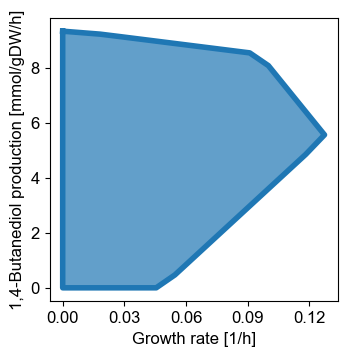

In [7]:
# load Strain Designer Instance
sda = SDA()
sda.load_strain_design_file(
    config.output_dir + "/gcOpt_summary_result_dict.pickle"
)

design_id = "design_134" # choose a strain design
# load design
getattr(sda.solutions, design_id).load()
# print flux space projections
ax = sda.flux_space_projection(target_rxn=target_reaction,
                               plot=True, dpi=100,
                               xlabel="Growth rate [1/h]", ylabel="1,4-Butanediol production [mmol/gDW/h]",
                               yield_space=False, yield_reference_reaction="EX_glc__D_e")

# ax = sda.flux_space_projection(target_rxn=target_reaction,
#                                plot=True, dpi=100,
#                                xlabel="Biomass yield [gDW/g]", ylabel="1,4-Butanediol yield [g/g]",
#                                unit_transformation_factors=unit_transformation_factors,
#                                yield_space=True, yield_reference_reaction="EX_glc__D_e")

In [8]:
# plot in flux map

builder = escher.Builder(
    map_json=str(MODEL_PATH.joinpath("e_coli_central_metabolism_butanediol_escher_map.json")),   
)
builder.model = sda.model # parse model of strain design

# calculate flux distribution by parsimonous flux balance analysis
sol = cobra.flux_analysis.pfba(sda.model)

# show flux distribution in map
builder.reaction_data = sol.fluxes
builder

Builder(reaction_data={'NDPK5': 0.0, 'SHK3Dr': 0.04853968001249196, 'NDPK6': 0.0, 'NDPK8': 0.0, 'DHORTS': -0.0…

90.121